
# 有限差分算例- Elliptic 方程求解

本节将引导您使用 FEALPy 完成 Elliptic 方程的有差分求解，现定义如下数学模型：

$$
\begin{cases}
-\nabla (A \nabla u) + b \nabla u + c u = f & \text{在 } \Omega = [0,1]^2 \\
u = g & \text{在 } \partial \Omega
\end{cases}
$$

其中我们定义真解为：

$$
u(x, y) = \sin(\pi x) \sin(\pi y)
$$

源项为：

$$
f(x,y) = (5\pi^2 + 4)\sin(\pi x) \sin(\pi y) + \pi \cos(\pi x) \sin(\pi y) - \pi \sin(\pi x) \cos(\pi y)
$$

系数为：

$$
A = \begin{pmatrix}
2 & 0 \\
0 & 3
\end{pmatrix}, \quad
b = \begin{pmatrix}
1 \\
-1
\end{pmatrix}, \quad
c = 4
$$


### 1. 定义 PDE 模型

In [1]:
from fealpy.backend import backend_manager as bm
from fealpy.decorator import cartesian

# 定义域
def domain():
    return [0, 1, 0, 1]

# 扩散项系数 A
def diffusion_coef():
    A = bm.tensor([[2.0, 0.0], [0.0, 3.0]])
    return A 

# 对流项系数 b
def convection_coef():
    b = bm.tensor([1.0, -1.0])
    return b

# 反应项系数 c
def reaction_coef():
    return 4.0

# 真解
@cartesian
def solution(p):
    x = p[..., 0]
    y = p[..., 1]
    pi = bm.pi
    val = bm.sin(pi*x)*bm.sin(pi*y)
    return val

# 源项
@cartesian
def source(p):
    x = p[..., 0]
    y = p[..., 1]
    pi = bm.pi
    sin = bm.sin
    cos = bm.cos
    term1 = (5*pi**2 + 4) * sin(pi*x) * sin(pi*y)
    term2 = pi * cos(pi*x) * sin(pi*y)
    term3 = -pi * sin(pi*x) * cos(pi*y)
    val = term1 + term2 + term3
    return val

# dirichlet 边界条件
@cartesian
def dirichlet(p):
    return solution(p)

### 2. 进行参数配置和初始化

设置后端

In [2]:
from fealpy.backend import backend_manager as bm

backend = 'numpy'
device = 'cpu'
bm.set_backend(backend)

导入日志工具

In [3]:
from fealpy.utils import timer
from fealpy import logger

logger.setLevel('WARNING')
tmr = timer()
next(tmr)

设置初始网格和加密次数

In [4]:
from fealpy.mesh import UniformMesh

mesh = UniformMesh(domain=domain(), extent=[0, 5, 0, 5])
maxit = 4

定义误差存储矩阵

In [5]:
errorMatrix = bm.zeros((1, maxit), dtype=bm.float64)

### 3. 有限差分求解

流程包含：

(1)从离散格式组装刚度矩阵 $A$ 和载荷向量 $F$

(2)处理 Dirichlet 边界条件

(3)求解线性系统 $A u_h = F$

(4)计算L2误差 $\|u - u_h\|_{L^2(\Omega)}$

(5)网格均匀加密


In [6]:
from fealpy.fdm import DiffusionOperator, ConvectionOperator, ReactionOperator, DirichletBC
from fealpy.solver import spsolve

for i in range(maxit):
    D = DiffusionOperator(mesh, diffusion_coef=diffusion_coef).assembly()
    C = ConvectionOperator(mesh, convection_coef=convection_coef).assembly()
    R = ReactionOperator(mesh, reaction_coef=reaction_coef).assembly()
    A = D + C + R

    node = mesh.entity("node")
    F = source(node)
    tmr.send(f'第{i}次矩阵组装时间')

    A, F = DirichletBC(mesh=mesh, gd=dirichlet).apply(A, F)
    tmr.send(f'第{i}次边界处理时间')

    uh = spsolve(A, F)
    tmr.send(f'第{i}次求解器时间')
    errorMatrix[0, i] = mesh.error(solution, uh, errortype='L2')
    if i < maxit-1:
        mesh.uniform_refine(n=1)
    tmr.send(f'第{i}次误差计算及网格加密时间')

### 4. 误差分析和收敛阶计算

In [7]:
next(tmr)
print("最终误差",errorMatrix)
print("order : ", errorMatrix[0,:-1]/errorMatrix[0,1:])

Timer received None and paused.
   ID       Time        Proportion(%)    Label
-------------------------------------------------
    1     26.537 [ms]           4.565    第0次矩阵组装时间
    2    264.883 [us]           0.046    第0次边界处理时间
    3    538.813 [ms]          92.685    第0次求解器时间
    4    309.229 [us]           0.053    第0次误差计算及网格加密时间
    5      2.499 [ms]           0.430    第1次矩阵组装时间
    6    297.308 [us]           0.051    第1次边界处理时间
    7    821.352 [us]           0.141    第1次求解器时间
    8    172.615 [us]           0.030    第1次误差计算及网格加密时间
    9      1.814 [ms]           0.312    第2次矩阵组装时间
   10    278.234 [us]           0.048    第2次边界处理时间
   11      1.426 [ms]           0.245    第2次求解器时间
   12    193.834 [us]           0.033    第2次误差计算及网格加密时间
   13      3.509 [ms]           0.604    第3次矩阵组装时间
   14    392.199 [us]           0.067    第3次边界处理时间
   15      3.950 [ms]           0.679    第3次求解器时间
   16     63.181 [us]           0.011    第3次误差计算及网格加密时间
最终误差 [[0.00298339 0.00531285 0.00363034

### 5. 结果可视化
在单元重心处计算真解和数值解，并进行可视化比较

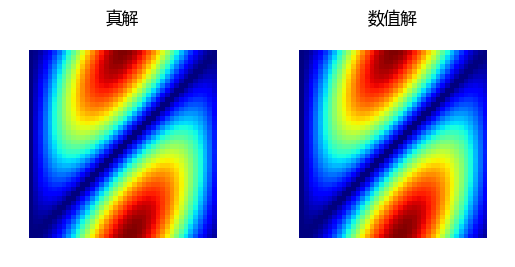

In [9]:
from matplotlib import pyplot as plt

node = mesh.entity('node')
u = solution(node)

fig, axes = plt.subplots(1, 2)
mesh.add_plot(axes[0], cellcolor=u, linewidths=0)
axes[0].set_title('真解', fontname='Microsoft YaHei')
mesh.add_plot(axes[1], cellcolor=uh, linewidths=0)
axes[1].set_title('数值解', fontname='Microsoft YaHei')
plt.show()